This notebook calculate g2 for each spatial and k-pixel to create r- and k-resolved relaxation time

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import SeqIO

In [2]:
%matplotlib notebook

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=16,
                      threads_per_worker=1,
                      dashboard_address=':8704')
client = Client(cluster)

distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-eq2vjrtr', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-b1e5yfso', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-6fvbd11x', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-yef49mrc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-vj510jcu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_PtNWs/dask-worker-space/worker-p1usvy9_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/srv/home/syhuang/Data/20220824_

In [4]:
import dask.array as da

In [5]:
strip = hs.load('strip_subpix.zspy',lazy=True)

In [6]:
strip.axes_manager

Navigation axis name,size,index,offset,scale,units
time,160,0,0.0,1.0,
y,160,0,0.0,1.0,
x,500,0,0.0,1.0,
Signal axis name,size,,offset,scale,units
Radians,180,,-3.141592653589793,0.03490658503988659,Rad
Radius,16,,0.3,0.01875,k_A^-1


In [7]:
klist = np.linspace(strip.axes_manager[-1].offset,strip.axes_manager[-1].offset+strip.axes_manager[-1].size*strip.axes_manager[-1].scale,strip.axes_manager[-1].size)

In [8]:
klist

array([0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 ,
       0.52, 0.54, 0.56, 0.58, 0.6 ])

In [9]:
strip_reg = hs.signals.Signal2D(da.from_zarr('strip_reg_rec.zarr')).as_lazy().transpose(navigation_axes=[1,2])

In [10]:
strip_reg.data

,Array,Chunk
Bytes,137.33 GiB,87.89 MiB
Shape,"(160, 160, 500, 16, 180)","(4, 4, 500, 16, 180)"
Count,1601 Tasks,1600 Chunks
Type,float32,numpy.ndarray


In [11]:
exp = strip_reg.inav[50,80].isig[:,:,:100]

In [12]:
exp.axes_manager[0].name = r'$\phi$'
exp.axes_manager[1].name = '$k$'
exp.axes_manager[0].scale = 2
exp.axes_manager[1].scale = 0.02
exp.axes_manager[1].offset = 0.3

<IPython.core.display.Javascript object>


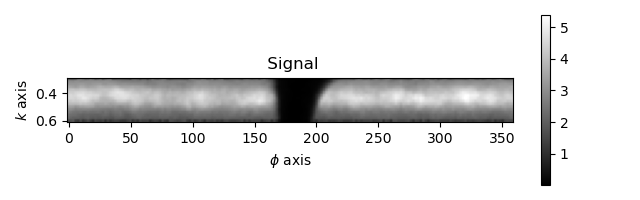

In [13]:
exp.mean(axis=-1).plot()

In [26]:
from scipy.optimize import curve_fit
from scipy import signal

In [15]:
def get_g2_2d(data,normalization='split',kbin=1,tbin=1):
    # returns k-average g2(t) form I(k_r,k_phi,t)
    # bs: [left,right] k_phi for the beamstop
    # kbin, tbin: binning factor for k and t
    data = data.T
    data = data.reshape((data.shape[0]//kbin),kbin, data.shape[1], (data.shape[2]//tbin), tbin).sum(4).sum(1)
    acorr = signal.fftconvolve(data,data[:,:,::-1],mode='full',axes=[-1])
    norm = signal.fftconvolve(np.ones(data.shape),data[:,:,::-1],mode='full',axes=[-1])
    if normalization == 'self':
        g2 = acorr[:,:,data.shape[-1]-1:]/norm[:,:,data.shape[-1]:0:-1]**2*np.expand_dims(np.linspace(data.shape[-1],1,data.shape[-1]), axis=(0, 1))
    if normalization == 'split':
        g2 = acorr[:,:,data.shape[-1]-1:]/norm[:,:,data.shape[-1]-1:]/norm[:,:,::-1][:,:,data.shape[-1]-1:]*np.expand_dims(np.linspace(data.shape[-1],1,data.shape[-1]), axis=(0, 1))
    
    return g2.T

In [17]:
def t_resampled(t_size,dt,t_rs_size):
    # returns resampled time array that evenly samples the log space
    # t_size: length of time array
    # dt: time intervals
    # t_rs_size: length of resampled time array
    t_rs = np.zeros(t_rs_size, dtype = np.float)
    
    for i in range(t_rs_size):
        t_rs[i] = np.power(10, np.log10(dt) + np.log10(t_size - 1)*i/(t_rs_size - 1))
        
    return t_rs

In [19]:
def g2_windowed_resampled_fullk(g2w,t_rs,dt):
    # returns g2(t) with resampled times
    # g2w: g2(t) in linear time
    # t_rs: resampled time array
    # dt: time intervals
    t = np.round(t_rs/dt,8)
    g2_l = g2w[np.floor(t).astype(int)]
    g2_h = g2w[np.ceil(t).astype(int)]
    g2_rs = g2_l + (g2_h - g2_l) * (t - np.floor(t).astype(int))[:,np.newaxis,np.newaxis]
    return g2_rs

In [20]:
def g2_windowed_resampled_fullk_estimate_a(g2w,t_rs,dt):
    # returns g2(t) with resampled times
    # normalized g2 for pre-exponential factor A
    # g2w: g2(t) in linear time
    # t_rs: resampled time array
    # dt: time intervals
    t = np.round(t_rs/dt,8)
    g2_l = g2w[np.floor(t).astype(int)]
    g2_h = g2w[np.ceil(t).astype(int)]
    g2_rs = g2_l + (g2_h - g2_l) * (t - np.floor(t).astype(int))[:,np.newaxis,np.newaxis]
    a = np.ones((g2w.shape[1],g2w.shape[2]))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i,j] = np.linalg.lstsq(np.vstack([[1,2,3,4], np.ones(4)]).T,g2w[1:5,i,j])[0][1]-1
    return (g2_rs-1)/a[np.newaxis]

In [24]:
def KWW_norm_curve(t, tau, beta):
    return np.exp(-2*np.power((t/tau),beta))

In [28]:
def KWW_fitting_err_normed(g2_rs,t_rs,tau_guess):
    # return fitting parameters tau and beta for KWW function
    # also returns estimated goodness of fit and errors
    # g2_rs: g2(t) with resampled times
    # t_rs: resampled time array
    # tau_guess: guess for parameter tau
    data = g2_rs
    std = np.sqrt(np.abs(data)/5*250/4000)
    #std = np.abs(data)/np.sqrt(5*250*4)
    indices = np.logical_and(~np.isnan(data),np.abs(data)<1.5)
    
    try:
        popt, pcov = curve_fit(KWW_norm_curve, t_rs[indices], data[indices], p0 = [tau_guess,1],sigma=std[indices],bounds=([1,0.1],[5000,2.5]))
        fitstd = np.sqrt(pcov[0,0])
        gof = np.nansum((KWW_norm_curve(t_rs[indices],*popt)-data[indices])**2/std[indices]**2)/(len(data[indices])-2)
        return [*popt,gof,fitstd]
    except:
        return [0,0,-1,0]

### Calculate k-resolved g2(r,k,t)

In [21]:
g2w = strip_reg.map(get_g2_2d,kbin=5,inplace=False)
trs = t_resampled(500,12.8,50)
#g2rs = g2w.map(g2_windowed_resampled_fullk,t_rs=trs,dt=12.8,inplace=False).transpose(signal_axes=[-1])

g2rsn = g2w.map(g2_windowed_resampled_fullk_estimate_a,t_rs=trs,dt=12.8,inplace=False).transpose(signal_axes=[-1])

/tmp/ipykernel_2178244/3666703439.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_rs = np.zeros(t_rs_size, dtype = np.float)
/tmp/ipykernel_2178244/2602056336.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a[i,j] = np.linalg.lstsq(np.vstack([[1,2,3,4], np.ones(4)]).T,g2w[1:5,i,j])[0][1]-1


In [22]:
g2rsn.data

,Array,Chunk
Bytes,5.49 GiB,3.52 MiB
Shape,"(160, 160, 16, 36, 50)","(4, 4, 16, 36, 50)"
Count,9601 Tasks,1600 Chunks
Type,float64,numpy.ndarray


In [ ]:
g2rsn.compute()

In [24]:
g2rsn.save('results/g2nk_2d.hspy',chunks=(10,10,16,36,50))

### Obtain k-resolved tau maps tau(r,k)

In [29]:
tbmapk_chi = g2rsn.map(KWW_fitting_err_normed,t_rs=t_resampled(500,12.8,50),tau_guess=50,inplace=False)

/tmp/ipykernel_2178244/3666703439.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_rs = np.zeros(t_rs_size, dtype = np.float)
/tmp/ipykernel_2178244/2602056336.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [30]:
tbmapk_chi.data

,Array,Chunk
Bytes,450.00 MiB,288.00 kiB
Shape,"(160, 160, 16, 36, 4)","(4, 4, 16, 36, 4)"
Count,12801 Tasks,1600 Chunks
Type,float64,numpy.ndarray


In [19]:
tbmapk_chi.compute()

<IPython.core.display.Javascript object>


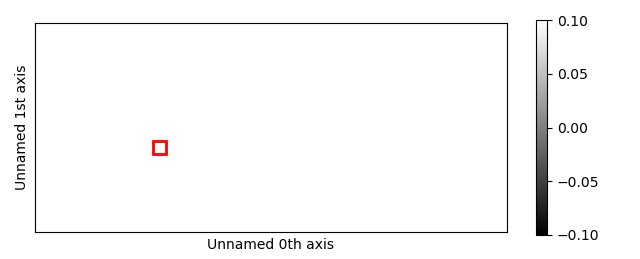

<IPython.core.display.Javascript object>


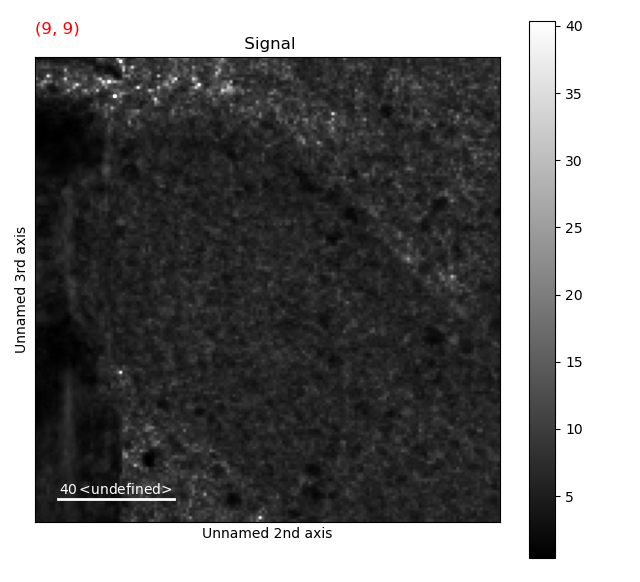

In [71]:
tbmapk_chi.isig[2].transpose(navigation_axes=[0,1]).plot()

In [34]:
tbmapk_chi.save('results/tbmap_nk_2d.hspy',chunks=(16,16,16,36,4))